<a href="https://colab.research.google.com/github/Casper0913/p9-energy/blob/main/Models/LSTM_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM (Long forecasting)
#### Sliding Window Forecasting - 3 years in, 1 year out

### Need for runnning colab

In [2]:
# !pip install torch torchvision torchaudio pandas numpy scikit-learn

# from google.colab import files
# uploaded = files.upload()

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Importing Data

In [3]:
import pandas as pd

# Correct the file path to the actual location of the CSV file
df = pd.read_csv('/Users/casper/Documents/GitHub/p9-energy/Dataset/ConsumptionIndustry.csv', sep=';')

# Load the dataset for colab
#df = pd.read_csv('ConsumptionIndustry.csv', sep=';')


# Convert HourDK to datetime
df['HourDK'] = pd.to_datetime(df['HourDK'])

# Convert ConsumptionkWh to numeric
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)


print(df.head())
print('\n')
print(df.tail())
print('\n')
print(df.info())
print('\n')

               HourUTC              HourDK  MunicipalityNo Branche  \
0  2020-12-31 23:00:00 2021-01-01 00:00:00             851  Privat   
1  2021-01-01 00:00:00 2021-01-01 01:00:00             851  Privat   
2  2021-01-01 01:00:00 2021-01-01 02:00:00             851  Privat   
3  2021-01-01 02:00:00 2021-01-01 03:00:00             851  Privat   
4  2021-01-01 03:00:00 2021-01-01 04:00:00             851  Privat   

   ConsumptionkWh  
0       37842.849  
1       35086.772  
2       31777.762  
3       28423.659  
4       25675.926  


                   HourUTC              HourDK  MunicipalityNo Branche  \
34291  2024-11-29 18:00:00 2024-11-29 19:00:00             851  Privat   
34292  2024-11-29 19:00:00 2024-11-29 20:00:00             851  Privat   
34293  2024-11-29 20:00:00 2024-11-29 21:00:00             851  Privat   
34294  2024-11-29 21:00:00 2024-11-29 22:00:00             851  Privat   
34295  2024-11-29 22:00:00 2024-11-29 23:00:00             851  Privat   

       Consu

## Data preperation + Feature Engineering

In [4]:
import numpy as np

df['HourDK'] = pd.to_datetime(df['HourDK'])

# # Lag features
df['ConsumptionkWh_lag1'] = df['ConsumptionkWh'].shift(1)
df['ConsumptionkWh_lag24'] = df['ConsumptionkWh'].shift(24)
df['ConsumptionkWh_lag168'] = df['ConsumptionkWh'].shift(168)


# Rolling Average
df['ConsumptionkWh_roll24'] = df['ConsumptionkWh'].rolling(window=24).mean()
df['ConsumptionkWh_roll168'] = df['ConsumptionkWh'].rolling(window=168).mean()

# Holidays in Denmark from 2021 to 2024 (source: https://publicholidays.dk/)
holidays = ['2021-01-01', '2021-04-01', '2021-04-02', '2021-04-05', '2021-05-13', '2021-05-21', '2021-06-01', '2021-06-24', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31', '2022-01-01', '2022-04-14', '2022-04-15', '2022-04-18', '2022-05-05', '2022-05-13', '2022-05-26', '2022-06-05', '2022-06-24', '2022-12-24', '2022-12-25', '2022-12-26',
            '2022-12-31', '2023-01-01', '2023-03-24', '2023-03-25', '2023-03-26', '2023-04-07', '2023-05-05', '2023-05-13', '2023-05-26', '2023-06-05', '2023-06-24', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-31', '2024-01-01', '2024-03-28', '2024-03-29', '2024-03-30', '2024-04-05', '2024-05-05', '2024-05-13', '2024-05-26', '2024-06-05', '2024-06-24']
holidays = pd.to_datetime(holidays)
df['is_holiday'] = df['HourDK'].dt.date.isin(holidays.date)

# Weekday and weekend flag
df['day_of_week'] = df['HourDK'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


# Hour of the Day (0-23) to sine/cosine transformation
df['hour_sin'] = np.sin(2 * np.pi * df['HourDK'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['HourDK'].dt.hour / 24)

# Day of the Week (0-6) to sine/cosine transformation
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Month of the Year (1-12) to sine/cosine transformation
df['month_sin'] = np.sin(2 * np.pi * df['HourDK'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['HourDK'].dt.month / 12)

# drop Nan values
df = df.dropna()

print(df.head())
print(df.info())

                 HourUTC              HourDK  MunicipalityNo Branche  \
168  2021-01-07 23:00:00 2021-01-08 00:00:00             851  Privat   
169  2021-01-08 00:00:00 2021-01-08 01:00:00             851  Privat   
170  2021-01-08 01:00:00 2021-01-08 02:00:00             851  Privat   
171  2021-01-08 02:00:00 2021-01-08 03:00:00             851  Privat   
172  2021-01-08 03:00:00 2021-01-08 04:00:00             851  Privat   

     ConsumptionkWh  ConsumptionkWh_lag1  ConsumptionkWh_lag24  \
168       28924.472            33787.185             29444.332   
169       26017.693            28924.472             26466.212   
170       24636.978            26017.693             24937.988   
171       24047.257            24636.978             24296.799   
172       24098.255            24047.257             24204.419   

     ConsumptionkWh_lag168  ConsumptionkWh_roll24  ConsumptionkWh_roll168  \
168              37842.849           42275.367875            42130.498304   
169             

## Splitting the dataet
* Training Set: From 2021-01-01 to 2023-06-30 (2.5 years)
* Validation Set: From 2023-07-01 to 2023-11-30 (5 months)
* Test Set: From 2023-12-01 to 2024-11-10 (approx. 11 months)

In [5]:
# Define date ranges for splitting
from torch.utils.data import Dataset, DataLoader

train_start = "2021-01-01"
train_end = "2023-06-30"
val_start = "2023-07-01"
val_end = "2023-11-30"
test_start = "2023-12-01"
test_end = "2024-11-10"

# Filter the dataset based on the date ranges
train_df = df[(df['HourDK'] >= train_start) & (df['HourDK'] <= train_end)]
val_df = df[(df['HourDK'] >= val_start) & (df['HourDK'] <= val_end)]
test_df = df[(df['HourDK'] >= test_start) & (df['HourDK'] <= test_end)]

# Print dataset sizes to verify
print(f"Training Set: {train_df.shape[0]} rows")
print(f"Validation Set: {val_df.shape[0]} rows")
print(f"Test Set: {test_df.shape[0]} rows")

Training Set: 21672 rows
Validation Set: 3650 rows
Test Set: 8281 rows


## Normalize
Normalize the features and convert to PyTorch-friendly formats

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the features
scaler = MinMaxScaler()
feature_cols = ['ConsumptionkWh_lag1', 'ConsumptionkWh_lag24', 'ConsumptionkWh_lag168',
                'ConsumptionkWh_roll24', 'ConsumptionkWh_roll168', 'hour_sin', 'hour_cos',
                'day_sin', 'day_cos', 'month_sin', 'month_cos']
target_col = 'ConsumptionkWh'

# Make explicit copies to avoid modifying slices
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

# Apply scaling to features (.loc for Explicit Indexing)
train_df.loc[:, feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df.loc[:, feature_cols] = scaler.transform(val_df[feature_cols])
test_df.loc[:, feature_cols] = scaler.transform(test_df[feature_cols])

# Apply scaling to the target column
train_df.loc[:, target_col] = scaler.fit_transform(train_df[[target_col]])
val_df.loc[:, target_col] = scaler.transform(val_df[[target_col]])
test_df.loc[:, target_col] = scaler.transform(test_df[[target_col]])

## Create PyTorch Datasets and DataLoaders
* Dataset stores the samples and their corresponding labels
* DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader


class EnergyDataset(Dataset):
  def __init__(self, data, feature_cols, target_col):
    self.features = torch.tensor(
        data[feature_cols].values, dtype=torch.float32)
    self.targets = torch.tensor(data[target_col].values, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    return self.features[idx], self.targets[idx]


# Create datasets
train_dataset = EnergyDataset(train_df, feature_cols, target_col)
val_dataset = EnergyDataset(val_df, feature_cols, target_col)
test_dataset = EnergyDataset(test_df, feature_cols, target_col)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## LSTM Model

In [8]:
import torch
import torch.nn as nn

class EnergyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        super(EnergyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #LSTM Forward Pass
        lstm_out, _ = self.lstm(x) # shape: (batch_size, seq_len, hidden_size)
        # Take the last output for predictions
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model Configuration
input_size = len(feature_cols) # Number of features
hidden_size = 128 # Number of features in hidden state
num_layers = 2 # Number of stacked LSTM layers
output_size = 1 # Number of output features
dropout = 0.1 # Dropout rate

# Instantiate the model
model = EnergyLSTM(input_size, hidden_size, num_layers, output_size, dropout=dropout)

### Define Loss Function and Optimizer

In [9]:
# Mean Squared Error Loss (L2 Loss)
criterion = nn.MSELoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model

#### Tensorboard logggin code

In [10]:
from sklearn.metrics import mean_absolute_error


def log_tensorboard(writer, model, optimizer, epoch, train_loss, val_loss, train_loader, val_loader, best_val_loss, patience_counter, input_size, device):
  # Log Traning and Validation Loss
  writer.add_scalar("Loss/Train", train_loss, epoch)
  writer.add_scalar("Loss/Validation", val_loss, epoch)

  # Log Learning Rate
  current_lr = optimizer.param_groups[0]['lr']
  writer.add_scalar("Learning Rate", current_lr, epoch)

  # Log Best Validation Loss
  writer.add_scalar("Loss/Best Validation", best_val_loss, epoch)

  # Log Gradient Norms
  total_norm = 0
  for p in model.parameters():
      if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
      total_norm = total_norm ** 0.5
      writer.add_scalar('Gradients/Norm', total_norm, epoch)

  # Log model weights and gradients
  for name, param in model.named_parameters():
      writer.add_histogram(f'Weights/{name}', param, epoch)
      if param.grad is not None:
          writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

  # Log validation predictions vs targets (every 10 epochs)
  if epoch % 10 == 0:
      sample_features, sample_targets = next(iter(val_loader))
      sample_features, sample_targets = sample_features.to(
          device), sample_targets.to(device)
      sample_predictions = model(sample_features.unsqueeze(1)).squeeze()
      writer.add_scalars(
          'Predictions vs Targets',
          {f'Prediction_{i}': pred.item()
           for i, pred in enumerate(sample_predictions[:5])},
          epoch
      )

  # Log validation MAE
  val_predictions = []
  val_targets = []
  with torch.no_grad():
      for batch in val_loader:
          features, targets = batch
          features, targets = features.to(device), targets.to(device)
          predictions = model(features.unsqueeze(1)).squeeze()
          val_predictions.append(predictions.cpu())
          val_targets.append(targets.cpu())

  val_predictions = torch.cat(val_predictions).numpy()
  val_targets = torch.cat(val_targets).numpy()
  mae = mean_absolute_error(val_targets, val_predictions)
  writer.add_scalar('Metrics/MAE', mae, epoch)

  # Log model graph (first epoch only)
  if epoch == 0:
    dummy_input = torch.randn(1, 10, input_size).to(
        device)  # Example: batch_size=1, seq_len=10
    try:
        scripted_model = torch.jit.script(model)
        writer.add_graph(scripted_model, dummy_input)
    except Exception as e:
        print(f"Error adding scripted model graph: {e}")

  # Log input data distributions (first epoch only)
  if epoch == 0:
      sample_features, _ = next(iter(train_loader))
      writer.add_histogram('Data/Input', sample_features, epoch)

  # Log early stopping metrics if patience is exceeded
  if patience_counter > 0:
      writer.add_scalar('EarlyStopping/Patience Counter',
                        patience_counter, epoch)
      writer.add_scalar('EarlyStopping/Best Validation Loss',
                        best_val_loss, epoch)

  # Log timing metrics
  import time
  epoch_time = time.time()
  writer.add_scalar('Timing/Epoch Duration', epoch_time, epoch)

In [11]:
from torch.utils.tensorboard import SummaryWriter

# Tensorboard
writer = SummaryWriter('Training_data/runs/lstm_long')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Training Loop
num_epochs = 100
patience = 50
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0

  for batch in train_loader:
    features, targets = batch

    # Move data to the GPU
    features, targets = features.to(device), targets.to(device)

    # Forward pass
    optimizer.zero_grad()
    target_prediction = model(features.unsqueeze(1)) # Add a channel dimension
    loss = criterion(target_prediction.squeeze(), targets)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  # Validation phase
  model.eval()
  val_loss = 0

  with torch.no_grad():
    for batch in val_loader:
      features, targets = batch
      features, targets = features.to(device), targets.to(device)
      target_prediction = model(features.unsqueeze(1))
      loss = criterion(target_prediction.squeeze(), targets)
      val_loss += loss.item()

  val_loss /= len(val_loader)

  log_tensorboard(writer, model, optimizer, epoch, train_loss, val_loss, train_loader, val_loader, best_val_loss, patience_counter, input_size, device)

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  # Early stopping and checkpointing
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), 'Training_data/lstm_energy_long.pth')
  else:
    patience_counter += 1
    if patience_counter > patience:
      print(f'Validation loss has not improved over the last {patience} epochs, stopping early')
      break

writer.close()
torch.save(model.state_dict(), 'Training_data/LSTM_Long.pth')

/opt/homebrew/Caskroom/miniconda/base/envs/testing_env/lib/python3.9/site-packages/torch/jit/_trace.py:687: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


Epoch 1/100, Train Loss: 0.0331, Validation Loss: 0.0077
Epoch 2/100, Train Loss: 0.0046, Validation Loss: 0.0016
Epoch 3/100, Train Loss: 0.0017, Validation Loss: 0.0013
Epoch 4/100, Train Loss: 0.0014, Validation Loss: 0.0011
Epoch 5/100, Train Loss: 0.0012, Validation Loss: 0.0010
Epoch 6/100, Train Loss: 0.0011, Validation Loss: 0.0009
Epoch 7/100, Train Loss: 0.0010, Validation Loss: 0.0009
Epoch 8/100, Train Loss: 0.0009, Validation Loss: 0.0008
Epoch 9/100, Train Loss: 0.0009, Validation Loss: 0.0008
Epoch 10/100, Train Loss: 0.0009, Validation Loss: 0.0008
Epoch 11/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 12/100, Train Loss: 0.0008, Validation Loss: 0.0008
Epoch 13/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 14/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 15/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 16/100, Train Loss: 0.0007, Validation Loss: 0.0007
Epoch 17/100, Train Loss: 0.0007, Validation Loss: 0.0007
Epoch 18/100, Train Los

# Evaluate the model

In [12]:
# Load the model
model.load_state_dict(torch.load('Training_data/lstm_energy_long.pth', weights_only=True))

# Set model to evaluation mode
model.eval()

# Collect predictions and targets
predictions, true_values = [], []

with torch.no_grad():
  for batch in test_loader:
    features, targets = batch
    features, targets = features.to(device), targets.to(device)

    # Forward pass
    output = model(features.unsqueeze(1))

    # Save predictions and true values
    predictions.append(output.cpu().numpy())
    true_values.append(targets.cpu().numpy())

# Flatten the list of NumPy arrays (from multiple batches) into a single array
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

### Common Evaluation Metrics for Regression

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mase = mean_absolute_error(true_values, predictions) / np.mean(np.abs(np.diff(true_values)))
sMAPE = 100 * np.mean(2 * np.abs(predictions - true_values) / (np.abs(true_values) + np.abs(predictions)))
mape = 100 * np.mean(np.abs(predictions - true_values) / np.abs(true_values))
r2 = r2_score(true_values, predictions)

# Print the performance metrics
print("Energy LSTM Model Performance:")
print("Total Traning time: 1min 21sec")
print("-------------------------------------")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

print('\n')
print(f"Mean Absolute Scaled Error: {mase:.2f}")
print(f"Symmetric Mean Absolute Percentage Error: {sMAPE:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")


# Save the results to a CSV file
results = {'mae': mae, 'mse': mse, 'rmse': rmse,
           'r2': r2, 'mase': mase, 'sMAPE': sMAPE, 'mape': mape}
results_df = pd.DataFrame(results, index=[0])
results_df.to_csv('Training_data/energy_transformer_results.csv', index=False)

Energy LSTM Model Performance:
Total Traning time: 1min 21sec
-------------------------------------
Mean Absolute Error: 0.02
Mean Squared Error: 0.00
Root Mean Squared Error: 0.03
R^2 Score: 0.96


Mean Absolute Scaled Error: 0.53
Symmetric Mean Absolute Percentage Error: 55.42
Mean Absolute Percentage Error: 79.99


### Visualize Model Performance

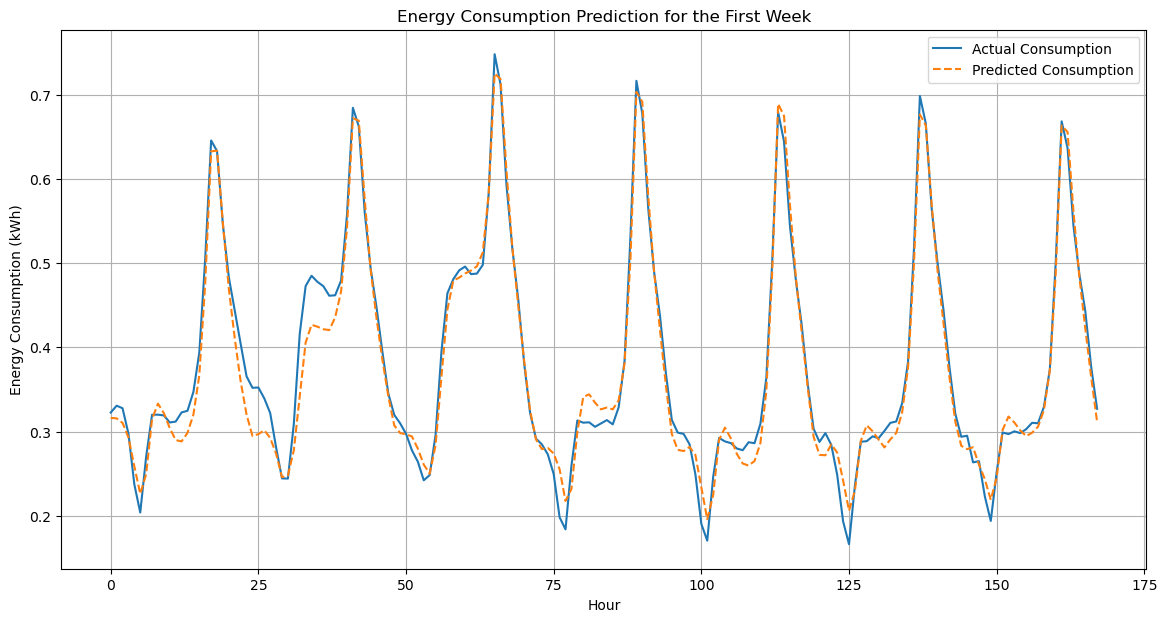

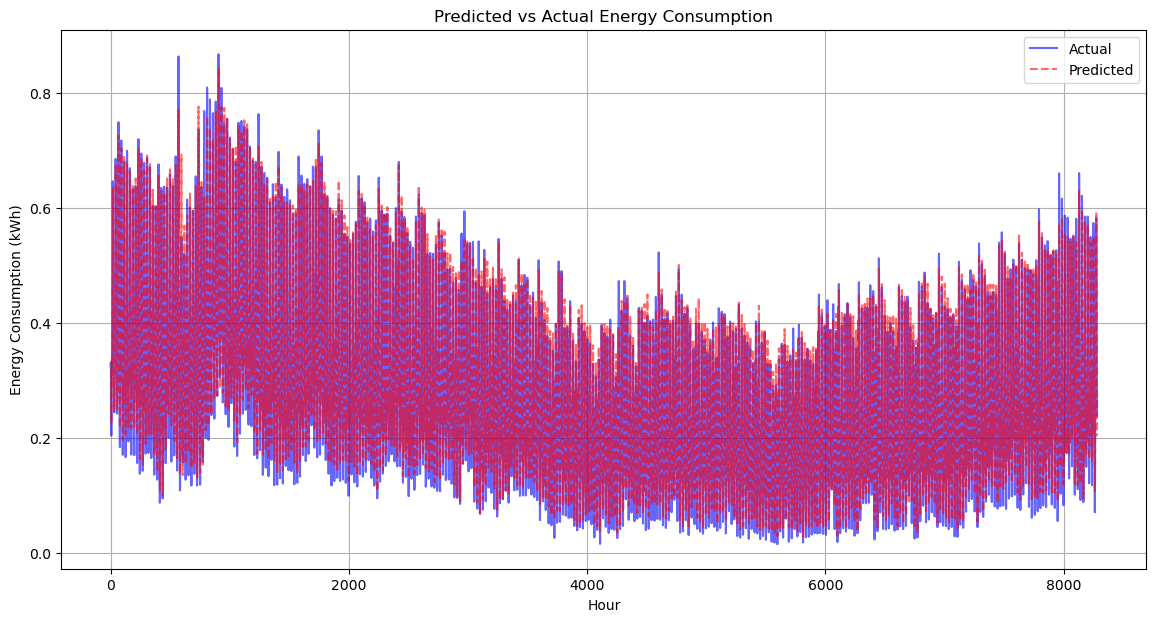

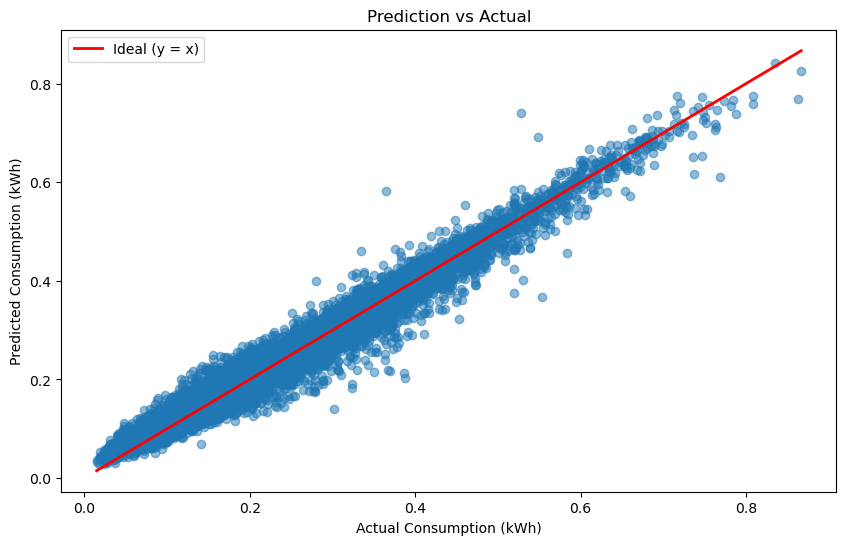

In [14]:
import matplotlib.pyplot as plt

# Plot the first week of predictions
plt.figure(figsize=(14, 7))
plt.plot(true_values[:24*7], label='Actual Consumption')
plt.plot(predictions[:24*7], label='Predicted Consumption', linestyle='--')
plt.title("Energy Consumption Prediction for the First Week")
plt.xlabel("Hour")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the entire test set
plt.figure(figsize=(14, 7))
plt.plot(true_values, label='Actual', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted',
         linestyle='--', color='red', alpha=0.6)
plt.title("Predicted vs Actual Energy Consumption")
plt.xlabel("Hour")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)],
         color='red', linewidth=2, label="Ideal (y = x)")
plt.xlabel("Actual Consumption (kWh)")
plt.ylabel("Predicted Consumption (kWh)")
plt.title("Prediction vs Actual")
plt.legend()
plt.show()

# # Plot the error distribution
# errors = true_values - predictions
# plt.figure(figsize=(10, 6))
# plt.hist(errors, bins=50, alpha=0.7)
# plt.title("Error Distribution")
# plt.xlabel("Prediction Error")
# plt.ylabel("Frequency")
# plt.show()

# Save the predictions and true values to a CSV file
results = pd.DataFrame({'Actual': true_values.flatten(),
                       'Predicted': predictions.flatten()})
results.to_csv('Training_data/energy_transformer_predictions.csv', index=False)

## Save data from traning om Google Colab as zip file

In [15]:
!zip -r LSTMTraning.zip Training_data/

2404.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


updating: Training_data/ (stored 0%)
updating: Training_data/.DS_Store (deflated 97%)
updating: Training_data/LSTM_Long.pth (deflated 8%)
updating: Training_data/energy_transformer_predictions.csv (deflated 57%)
updating: Training_data/energy_transformer_results.csv (deflated 25%)
updating: Training_data/lstm_energy_long.pth (deflated 8%)
updating: Training_data/energy_transformer.pth (deflated 19%)
updating: Training_data/runs/ (stored 0%)
updating: Training_data/runs/energy_transformer/ (stored 0%)
updating: Training_data/runs/energy_transformer/events.out.tfevents.1732788824.MacBookPro.lan.17950.6 (deflated 95%)
updating: Training_data/runs/energy_transformer/events.out.tfevents.1732794416.MacBookPro.lan.17950.18 (deflated 95%)
updating: Training_data/runs/energy_transformer/Predictions vs Targets_Prediction_2/ (stored 0%)
updating: Training_data/runs/energy_transformer/Predictions vs Targets_Prediction_2/events.out.tfevents.1732788842.MacBookPro.lan.17950.15 (deflated 53%)
updating